# Задача

На сайте запущен А/В тест с целью увеличить доход. В приложенном excel файле вы найдете сырые данные по результатам эксперимента – user_id, тип выборки variant_name и доход принесенный пользователем revenue.
Проанализируйте результаты эксперимента и напишите свои рекомендации менеджеру.

In [1]:

from tqdm import tqdm # Прогресс бар

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from statsmodels.stats.meta_analysis import effectsize_smd
from statsmodels.stats import proportion
from statsmodels.stats.power import tt_ind_solve_power
from statsmodels.stats.power import zt_ind_solve_power


In [2]:
from scipy.stats import ttest_1samp
import numpy as np

import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')



## Подготовка данных к анализу

### Загружаем сырые данные для анализа

In [3]:
raw_data = pd.read_excel('data/gb_sem_8_hm.xlsx')

In [4]:
raw_data.head(10)

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0
5,2380,variant,0.0
6,2849,control,0.0
7,9168,control,0.0
8,6205,variant,0.0
9,7548,control,0.0


In [5]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [6]:
raw_data.shape

(10000, 3)

In [7]:
raw_data.isnull().sum()

USER_ID         0
VARIANT_NAME    0
REVENUE         0
dtype: int64

In [8]:
data = raw_data.drop_duplicates(['USER_ID','VARIANT_NAME'])

In [9]:
data.groupby('USER_ID', as_index=False).agg({'VARIANT_NAME': 'count'})['VARIANT_NAME'].value_counts()

1    4783
2    1541
Name: VARIANT_NAME, dtype: int64

In [10]:
doubles = data.groupby('USER_ID').agg({'VARIANT_NAME' : 'nunique'}).reset_index().query('VARIANT_NAME>1')['USER_ID'].unique()

In [11]:
data = data.query('USER_ID not in @doubles')

In [12]:
data.describe()

,USER_ID,REVENUE
count,4783.000000,4783.000000
mean,4994.395777,0.110138
std,2898.618472,2.948720
min,2.000000,0.000000
25%,2476.000000,0.000000
50%,4975.000000,0.000000
75%,7515.000000,0.000000
max,9998.000000,196.010000


## Анализ

In [13]:
variant = data[data['VARIANT_NAME'] =='variant'].copy(deep=True)
control = data[data['VARIANT_NAME'] =='control'].copy(deep=True)

In [14]:
variant[['REVENUE']].describe()

,REVENUE
count,2393.000000
mean,0.065382
std,0.838523
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,23.040000


In [15]:
variant.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2393 entries, 0 to 9996
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       2393 non-null   int64  
 1   VARIANT_NAME  2393 non-null   object 
 2   REVENUE       2393 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 74.8+ KB


In [16]:
control[['REVENUE']].describe()

,REVENUE
count,2390.000000
mean,0.154950
std,4.086128
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,196.010000


In [17]:
control.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2390 entries, 7 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       2390 non-null   int64  
 1   VARIANT_NAME  2390 non-null   object 
 2   REVENUE       2390 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 74.7+ KB


Получим значения, которые потребуются для расчета мощности теста

In [18]:
variant_mean = variant.describe().loc['mean','REVENUE']
variant_std = variant.describe().loc['std','REVENUE']
control_mean = control.describe().loc['mean','REVENUE']
control_std = control.describe().loc['std','REVENUE']

print(f'Среднее значение в контрольной выборке {variant_mean} \n стандартное отклонение {variant_std}')
print(f'Среднее значение в тестовой выборке {control_mean} \n стандартное отклонение {control_std}')

Среднее значение в контрольной выборке 0.06538236523192645 
 стандартное отклонение 0.83852331659978
Среднее значение в тестовой выборке 0.1549497907949791 
 стандартное отклонение 4.0861281090276265


Сравнив контрольную и тестовую группы по показателю 'доход' ('REVENUE'), видим, отличия в средних значениях и максимальных. Сильное различие в максимальных значениях может свидетельствовать о наличии 'выбросов'. Разницы в полученном доходе практически нет. По своему размеру выборки почти идентичны.

### Визуализация

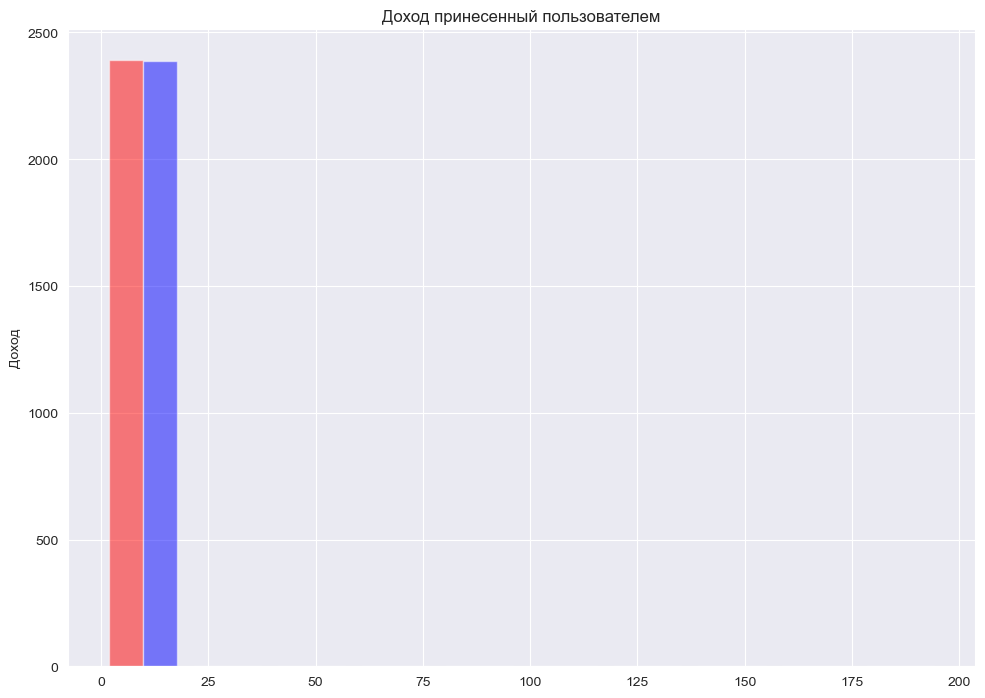

In [19]:
plt.figure(figsize = (11.7, 8.27))
sns.set_style("darkgrid") 
plt.hist([variant['REVENUE'], control['REVENUE']], color=['r','b'], alpha=0.5)
plt.ticklabel_format(style='plain', axis='x')
plt.title('Доход принесенный пользователем');
plt.ylabel('Доход');
#plt.hist([variant['REVENUE'], control['REVENUE']], color=['r','b'], alpha=0.5)

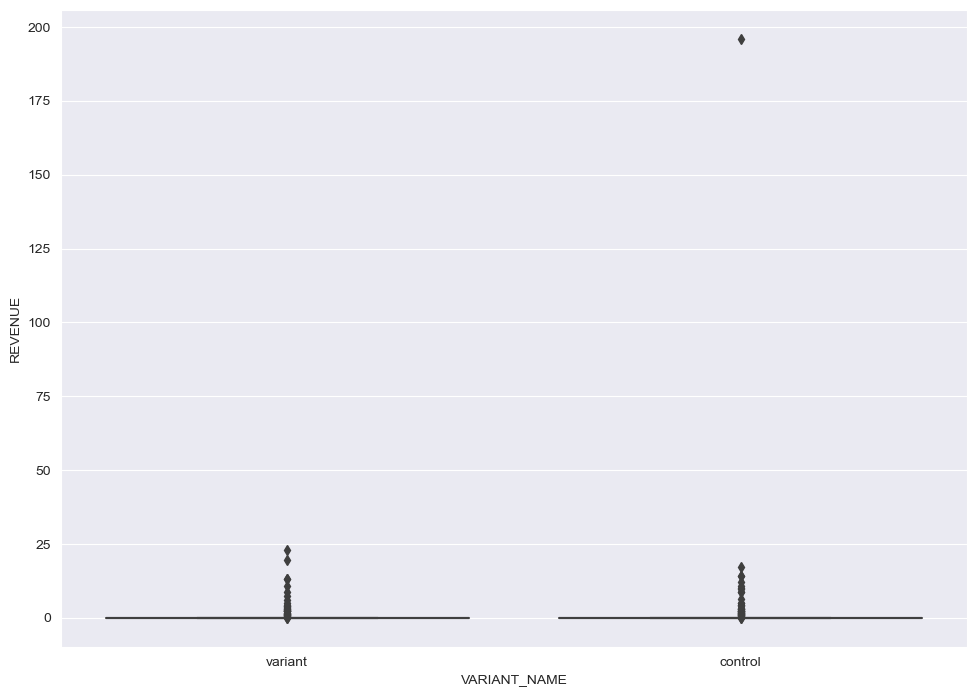

In [20]:
plt.figure(figsize = (11.7, 8.27))
sns.boxplot(x=data['VARIANT_NAME'], y=data['REVENUE'], data=data)
plt.show()

Визуализация подверждает наличие 'выброса'

### Проверка данных на нормальность распределения

Проверим данные на нормальность с помощью критерия Шапиро-Уилка и графическим методом с использованием Q-Q plot

In [21]:
stats.shapiro(control['REVENUE'])

ShapiroResult(statistic=0.015025436878204346, pvalue=0.0)

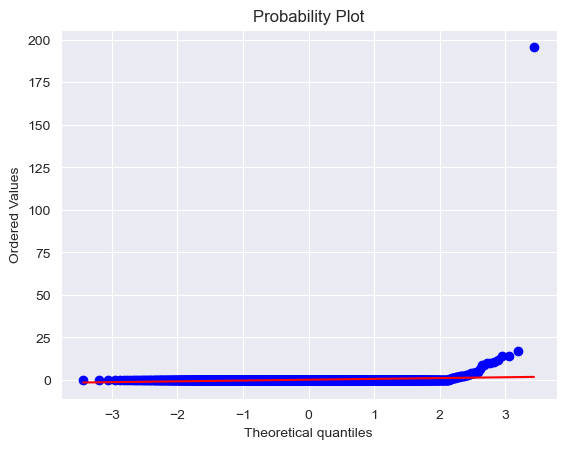

In [22]:
stats.probplot(control['REVENUE'], dist="norm", plot=plt)
plt.show()

Результаты анализа подтверждают, что данные текущей версии распределены не нормально. По критерию Шапиро-Уилка значение P-value < alpha (5%.)

In [23]:
stats.shapiro(variant['REVENUE'])

ShapiroResult(statistic=0.0516657829284668, pvalue=0.0)

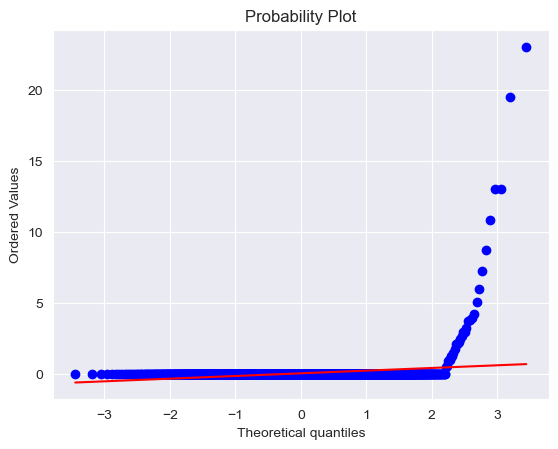

In [24]:
stats.probplot(variant['REVENUE'], dist="norm", plot=plt)
plt.show()

Результаты анализа подтверждают, что данные в тестовой выборке тоже не имеют нормального распределения. По критерию Шапиро-Уилка значение P-value < alpha (5%.)

### Сравнение выборок

In [25]:
stats.ttest_ind(variant['REVENUE'],control['REVENUE'], equal_var = False)

Ttest_indResult(statistic=-1.049762021384409, pvalue=0.293925496211077)

In [26]:
stats.mannwhitneyu(variant['REVENUE'],control['REVENUE'])

MannwhitneyuResult(statistic=2852373.0, pvalue=0.47685753584007984)

По полученным результатам, видим что p-value > уровня статистической значимости, а значит нулевая гипотеза о том, что стастически значимых отличий между выборками нет верна.

### Расчет мощности теста

In [27]:
print(len(control.REVENUE.values), len(variant.REVENUE.values))

2390 2393


In [28]:
n = len(control.REVENUE.values)

In [29]:
s_pooled = np.sqrt((control_std**2 + variant_std**2)/2)
print(s_pooled)

2.949539309440305


In [30]:
effect =float((control_mean - variant_mean)/s_pooled)
print(effect)

0.03036658141031816


In [31]:
#подсчет с помощью встроенной функции
ef1 = effectsize_smd(control_mean,control_std,len(control.REVENUE.values),variant_mean,variant_std,len(variant.REVENUE.values))
print(ef1)

(0.030370577211908504, 0.0008363920426140521)


In [32]:
alpha = 0.05
result_power = tt_ind_solve_power(effect, power = None, nobs1 = n, ratio = 1.0, alpha = alpha)
result_power
beta = 1-result_power
print(result_power,beta)

0.18260381671210682 0.8173961832878932


### Проверка через функцию


In [33]:
def continious_result(control: pd.DataFrame,
                      treatment: pd.DataFrame,
                      column: str,
                      n_iters: int = 10_000) -> pd.DataFrame:
    # Статистика по выборкам
    size = control.loc[:, column].shape[0]
    
    control_mean = control.loc[:, column].mean()
    treatment_mean = treatment.loc[:, column].mean()
    
    control_std = control.loc[:, column].std(ddof=1)
    treatment_std = treatment.loc[:, column].std(ddof=1)
    
    # Бутсрап
    booted_diff = []
    for _ in tqdm(range(n_iters)):
        control_sample = control.loc[:, column].sample(n=size, replace=True).values
        treatment_sample = treatment.loc[:, column].sample(n=size, replace=True).values
        booted_diff.append(np.mean(control_sample - treatment_sample))
    
    # Считаем статистику после бустрапа
    md_ci, std_ci = np.mean(booted_diff), np.std(booted_diff, ddof=1)
    left_ci, right_ci = np.percentile(booted_diff, [2.5, 97.5])
    p_value_ci = 2 * (1 - stats.norm.cdf(np.abs(md_ci / std_ci)))
    
    # Считаем мощность эксперимента
    effect_size, _ = effectsize_smd(mean1=treatment_mean, sd1=treatment_std, nobs1=size,
                                    mean2=control_mean, sd2=control_std, nobs2=size)
    power = tt_ind_solve_power(effect_size=effect_size,
                               nobs1=size,
                               alpha=.05,
                               power=None,
                               ratio=1)
    # Формируем отчёт 
    result = pd.DataFrame({'effect_size': effect_size,
                           'alpha': p_value_ci, 
                           'beta': (1-power),
                           'CI': f'[{np.round(left_ci, 3)}, {np.round(right_ci, 3)}]',
                           'difference': md_ci,},
                          index=[column]) 
    return result

In [34]:
continious_result(variant,control, column='REVENUE')

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1401.89it/s]


,effect_size,alpha,beta,CI,difference
REVENUE,0.030362,0.297858,0.817268,"[-0.299, 0.028]",-0.09062


### Выводы

*    После сравнения контрольной и тестовой групп, статистических различий не наблюдается
* Значение p-value >5%, вероятность получить ошибку второго рода beta = 81%, доверительный интервал включает в себя нулевое значение.
*    В исходном наборе данных обнаружены ошибки (много повторных значений, пользователи находились одновременно в обоих группах). 
* Рекомендуется провести A/A тест для проверки корректной работы системы сплитования. 
*   При необходимости в подобном тестировании, внести корректировки в настройки A/B теста.
* Повторно провести A/B тестирование. 